In [1]:
%load_ext autoreload
%autoreload

#!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

import matplotlib.pyplot as plt

import json

In [2]:
import l5pc_model
import l5pc_evaluator

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=False)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()
l5pc_cell = ephys.models.LFPyCellModel('l5pc', morph=morphology, mechs=mechanisms, params=parameters)
param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      
fitness_protocols = l5pc_evaluator.define_protocols()
feature_configs = json.load(open('config/features.json'))
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)
sim = ephys.simulators.LFPySimulator(l5pc_cell)
evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=l5pc_cell,                                                       
                param_names=param_names,                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim) 

In [3]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

In [4]:
# Check if the cell is loaded properly
#l5pc_cell.unfreeze(release_params)
#l5pc_cell.freeze(release_params)
#l5pc_cell.instantiate(sim=evaluator.sim)
#evaluator.sim.neuron.h.topology()
#pprint.pprint(l5pc_cell.params)
#l5pc_cell.destroy(sim=evaluator.sim)

In [5]:
release_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=release_params)

/gpfs/bbp.cscs.ch/home/damart/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


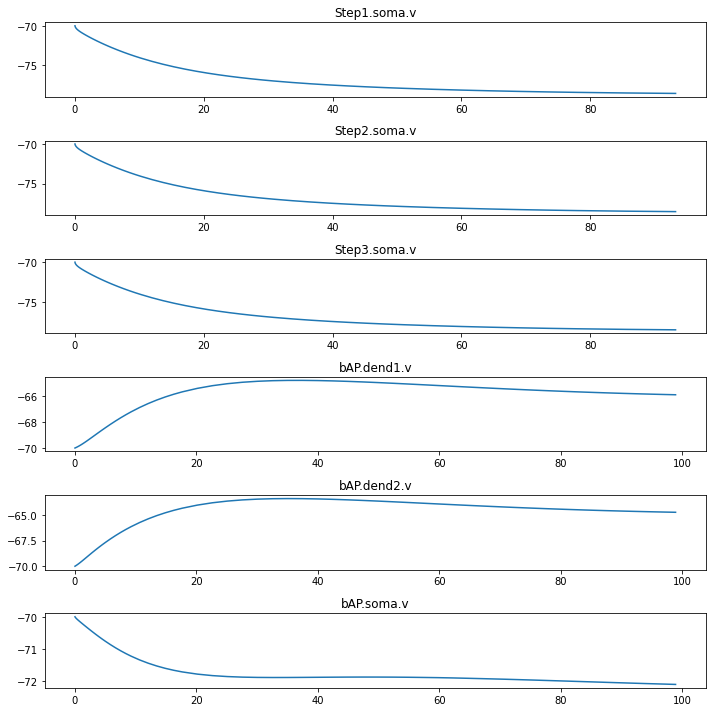

In [6]:
def plot_responses(responses):
    fig, axes = plt.subplots(len(responses), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()
plot_responses(release_responses)

In [ ]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=4) 
final_pop, halloffame, log, hist = opt.run(max_ngen=4, cp_filename='checkpoints/checkpoint.pkl')

In [ ]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))

In [ ]:
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)
plot_responses(best_responses)